<a href="https://colab.research.google.com/github/AnandSaumya/Finance/blob/main/Finance_Text_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Using BERT to Predict a Company's Asset Intensity (Text Analysis)

###The goal of this notebook is to show the possibilities of predicting financial outcomes from textual data via DistilBERT transformer model.

This notebook builds uses Business Decriptions from Google Finance

(Example: See textual **Description** of AAPL (in this case from Yahoo Finance))"

[link text](https://finance.yahoo.com/quote/AAPL/profile?p=AAPL)

This Colab notebook uses the following files that are posted on the class webite:
*   `company_des.csv` with Company descriptions of a large number of companues from Yahoo Finance

*   `ta.csv` and `rev.csv` with total assets and revenue data. This financial data was downloaded from Yahoo Finance

The steps this ipynb goes through are below:

1.   Upload `stock_des.csv` , ta.csv` and `rev.csv' from your local machine to the Colab working directory.
2.   Install and load the necessary libraries.
3.   Load, merge, clean the data.
4.   Create the label variable.
5.   Prepare the predictor.  
6.   Run the DistilBERT model.
7.   Train logistic regression and evaluate its accuracy.





**Note**. Save this Colab notebook to your Drive via File > Save a copy in Drive to be able to edit it.

# 1. Upload data files

Please upload the necessary files (`stock_des.csv`, `ta.csv`, `rev.csv`) in your `project_folder` folder.

You can upload the files via `files.upload()` code cell below OR use the upload function in the window to the left (lcik on folder icon and then click on upload icon).

In [ ]:
# Upload data
from google.colab import files
uploaded = files.upload()

Saving Assignment-3-Saumya-Anand.csv to Assignment-3-Saumya-Anand.csv
Saving stock_des.csv to stock_des.csv


# 2. Install, load the libraries

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print('Device:', torch.device('cuda:0'))

Device: cuda:0


In [ ]:
#torch.cuda.get_device_name(0)

# 2. Load, merge, clean the data

## 2.1 Loading and merging the data

In [ ]:
# Load the csv files
stock_des = pd.read_csv('stock_des.csv')
stock=pd.read_csv("/content/Assignment-3-Saumya-Anand.csv")

After loading the files, I changed the column name from `tic` to `ticker` so that the merging can be done on the common column name.

In [ ]:
# Renaming column name in the stocks file
stock.rename(columns={'tic': 'ticker'}, inplace=True)

In [ ]:
# Merge the dataframes into one
stock = pd.merge(stock, stock_des, on='ticker')

In [ ]:
# Printing the merged dataframe
stock

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,ticker,conm,curcd,act,at,dltt,lct,sale,costat,description
0,1004,5/31/2023,2022,INDL,C,D,STD,AIR,AAR CORP,USD,1097.900,1833.100,317.900,351.500,1990.600,A,AAR Corp. provides products and services to co...
1,1045,12/31/2023,2023,INDL,C,D,STD,AAL,AMERICAN AIRLINES GROUP INC,USD,13572.000,63058.000,35722.000,22062.000,52788.000,A,"American Airlines Group Inc., through its subs..."
2,1075,12/31/2023,2023,INDL,C,D,STD,PNW,PINNACLE WEST CAPITAL CORP,USD,1926.967,24661.153,8750.811,2889.347,4695.991,A,"Pinnacle West Capital Corporation, through its..."
3,1078,12/31/2023,2023,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,USD,22670.000,73214.000,14548.000,13841.000,40109.000,A,"Abbott Laboratories discovers, develops, manuf..."
4,1161,12/31/2023,2023,INDL,C,D,STD,AMD,ADVANCED MICRO DEVICES,USD,16768.000,67885.000,2252.000,6689.000,22680.000,A,"Advanced Micro Devices, Inc. operates as a sem..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,317264,3/31/2023,2022,INDL,C,D,STD,LPG,DORIAN LPG LTD,USD,236.299,1708.914,739.039,94.597,392.151,A,"Dorian LPG Ltd., together with its subsidiarie..."
1255,325576,12/31/2023,2023,INDL,C,D,STD,APG,API GROUP CORPORATION,USD,2582.000,7590.000,2494.000,1807.000,6928.000,A,"APi Group Corporation provides safety, special..."
1256,326688,12/31/2023,2023,INDL,C,D,STD,NVT,NVENT ELECTRIC PLC,USD,1336.100,6161.700,1847.200,733.600,3263.600,A,"nVent Electric plc designs, manufactures, mark..."
1257,328795,12/31/2023,2023,INDL,C,D,STD,ACA,ARCOSA INC,USD,912.000,3577.900,591.600,431.200,2307.900,A,"Arcosa, Inc., together with its subsidiaries, ..."


## 2.2 Cleaning the data

In [ ]:
# Examining the columns
stock.columns

Index(['gvkey', 'datadate', 'fyear', 'indfmt', 'consol', 'popsrc', 'datafmt',
       'ticker', 'conm', 'curcd', 'act', 'at', 'dltt', 'lct', 'sale', 'costat',
       'description'],
      dtype='object')

Subsequently, the unqiue values of each of the columns were printed that were susceptible to just having one value. These columns were dropped as they would not provide much to the models.

In [ ]:
# Examining unique values, if any, in the `fyear` column
stock['fyear'].value_counts()

fyear
2023    1103
2022     156
Name: count, dtype: int64

In [ ]:
# Examining unique values, if any, in the `indfmt` column
stock['indfmt'].value_counts()

indfmt
INDL    1259
Name: count, dtype: int64

In [ ]:
# Examining unique values, if any, in the `consol` column
stock['consol'].value_counts()

consol
C    1259
Name: count, dtype: int64

In [ ]:
# Examining unique values, if any, in the `popsrc` column
stock['popsrc'].value_counts()

popsrc
D    1259
Name: count, dtype: int64

In [ ]:
# Examining unique values, if any, in the `datafmt` column
stock['datafmt'].value_counts()

datafmt
STD    1259
Name: count, dtype: int64

In [ ]:
# Examining unique values, if any, in the `curcd` column
stock['curcd'].value_counts()

curcd
USD    1259
Name: count, dtype: int64

In [ ]:
# Examining unique values, if any, in the `costat` column
stock['costat'].value_counts()

costat
A    1259
Name: count, dtype: int64

In [ ]:
# Dropping the columns not needed for analysis
cols_to_drop=['indfmt','consol','popsrc','datafmt','curcd','costat']
stock=stock.drop(cols_to_drop,axis=1)
stock

,gvkey,datadate,fyear,ticker,conm,act,at,dltt,lct,sale,description
0,1004,5/31/2023,2022,AIR,AAR CORP,1097.900,1833.100,317.900,351.500,1990.600,AAR Corp. provides products and services to co...
1,1045,12/31/2023,2023,AAL,AMERICAN AIRLINES GROUP INC,13572.000,63058.000,35722.000,22062.000,52788.000,"American Airlines Group Inc., through its subs..."
2,1075,12/31/2023,2023,PNW,PINNACLE WEST CAPITAL CORP,1926.967,24661.153,8750.811,2889.347,4695.991,"Pinnacle West Capital Corporation, through its..."
3,1078,12/31/2023,2023,ABT,ABBOTT LABORATORIES,22670.000,73214.000,14548.000,13841.000,40109.000,"Abbott Laboratories discovers, develops, manuf..."
4,1161,12/31/2023,2023,AMD,ADVANCED MICRO DEVICES,16768.000,67885.000,2252.000,6689.000,22680.000,"Advanced Micro Devices, Inc. operates as a sem..."
...,...,...,...,...,...,...,...,...,...,...,...
1254,317264,3/31/2023,2022,LPG,DORIAN LPG LTD,236.299,1708.914,739.039,94.597,392.151,"Dorian LPG Ltd., together with its subsidiarie..."
1255,325576,12/31/2023,2023,APG,API GROUP CORPORATION,2582.000,7590.000,2494.000,1807.000,6928.000,"APi Group Corporation provides safety, special..."
1256,326688,12/31/2023,2023,NVT,NVENT ELECTRIC PLC,1336.100,6161.700,1847.200,733.600,3263.600,"nVent Electric plc designs, manufactures, mark..."
1257,328795,12/31/2023,2023,ACA,ARCOSA INC,912.000,3577.900,591.600,431.200,2307.900,"Arcosa, Inc., together with its subsidiaries, ..."


In [ ]:
# Summary statistics
stock.describe()

,gvkey,fyear,act,at,dltt,lct,sale
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000
mean,55287.156473,2022.876092,4185.450146,15007.152226,4764.810666,3397.793346,11040.712597
std,66187.341995,0.329607,12451.442825,40740.903569,12833.729458,11161.375760,35358.741647
min,1004.000000,2022.000000,5.280000,6.262000,0.007000,1.833000,0.682000
25%,9774.000000,2023.000000,369.953500,952.170500,161.001500,154.964500,714.596000
50%,25389.000000,2023.000000,990.200000,2809.400000,827.585000,523.400000,2259.813000
75%,65425.500000,2023.000000,2932.500000,10489.876000,3337.188000,1922.875500,7355.350000
max,345920.000000,2023.000000,184257.000000,527854.000000,157703.000000,164917.000000,574785.000000


In [ ]:
# Checking for nulls
stock.isnull().sum()

gvkey          0
datadate       0
fyear          0
ticker         0
conm           0
act            0
at             0
dltt           0
lct            0
sale           0
description    0
dtype: int64

# 3. Computing the financial ratios

It can be seen that there are no nulls in the values that were selected for the calulcation of the ratios. This seems like a good thing for the analysis as these would give the maximum number of actual values that would be beneficial for the models.

The ratios that I decided to include for the analysis are:

- `Asset Turnover Ratio`:
  - The Asset Turnover Ratio measures a company's efficiency in generating revenue from its assets. It's calculated by dividing the company's net sales (`sale`) by its total assets (`at`).
  - Textual business descriptions often provide insights into a company's operational activities which include the utilization of assets to drive revenue generation.
  - For instance, retail, consumer staples and IT sectors have relatively small asset bases but high sales volume, resulting in a higher average asset turnover ratio. Conversely, firms in utilities and real estate sectors have large asset bases and low asset turnover ratios.
  -  Including this ratio could help figure out the type of companies that operate with relatively low physical assets and high levels of intangible assets, such as intellectual property, software, and human capital.

- `Working Capital Ratio`:
  - The Working Capital Ratio measures a company's ability to cover its short-term liabilities with its short-term assets.
  - It's calculated by dividing current assets (`act`) by current liabilities (`lct`).
  - It should be noted that generally, retails require much more working capital than Tech companies or other companies, thus making it easier to identify companies involved in these sectors.

- `Long term Debt to Assets Ratio`
  - The Long-term Debt to Assets Ratio measures a company's solvency by comparing its long-term debt to its total assets.
  - It's calculated by dividing long-term debt (`dltt`) by total assets (`at`).
  - Companies that invest a lot in assets and operations often have higher debt ratios. For instance, utilities and airlines tend to have higher debt ratios than other industries, like the technology sector.


Overall, these ratios can help identify companies based on their long term debt and assets. By looking into these specific ratios, a measure of the companies business operations can be understood if any of these ratio is particularly high or low.

In [ ]:
# Calculating the asset turnover taio, working capital ratio and the long term debt to assets ratio
stock['asset_turnover_ratio']=stock['sale']/stock['at']
stock['working_capital_ratio']=stock['act']/stock['lct']
stock['long_term_debt_to_assets_ratio']=stock['dltt']/stock['at']

In [ ]:
# Checking for nulls
stock.isnull().sum()

gvkey                             0
datadate                          0
fyear                             0
ticker                            0
conm                              0
act                               0
at                                0
dltt                              0
lct                               0
sale                              0
description                       0
asset_turnover_ratio              0
working_capital_ratio             0
long_term_debt_to_assets_ratio    0
dtype: int64

count    1259.000000
mean        0.877876
std         0.615996
min         0.001524
25%         0.454473
50%         0.726342
75%         1.175756
max         4.721929
Name: asset_turnover_ratio, dtype: float64 

count    1259.000000
mean        2.464108
std         2.278798
min         0.190618
25%         1.230705
50%         1.821040
75%         2.887192
max        24.997202
Name: working_capital_ratio, dtype: float64 

count    1259.000000
mean        0.316309
std         0.258246
min         0.000019
25%         0.155887
50%         0.288017
75%         0.409754
max         3.053086
Name: long_term_debt_to_assets_ratio, dtype: float64 



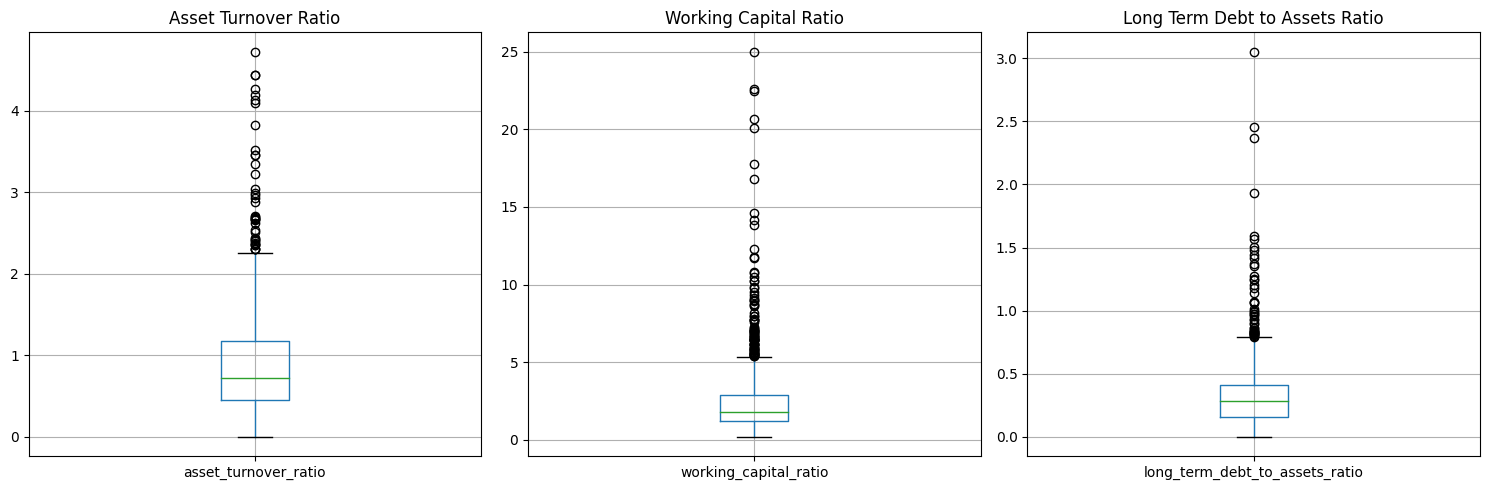

In [ ]:
# Creating a figure and axes object
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plotting asset turnover ratio
print(stock['asset_turnover_ratio'].describe(), '\n')
stock.boxplot(column='asset_turnover_ratio', ax=axes[0])
axes[0].set_title('Asset Turnover Ratio')

# Plotting working capital ratio
print(stock['working_capital_ratio'].describe(), '\n')
stock.boxplot(column='working_capital_ratio', ax=axes[1])
axes[1].set_title('Working Capital Ratio')

# Plotting long term debt to assets ratio
print(stock['long_term_debt_to_assets_ratio'].describe(), '\n')
stock.boxplot(column='long_term_debt_to_assets_ratio', ax=axes[2])
axes[2].set_title('Long Term Debt to Assets Ratio')

plt.tight_layout()
plt.show()

From the above boxplots it can be seen that all the three ratios have a lot of outliers, instead of dropping them, I'll wincorize them to get more datapoints for the model.

In [ ]:
from scipy.stats.mstats import winsorize

stock['asset_turnover_ratio']= winsorize(stock['asset_turnover_ratio'],limits=[0.01,0.01]) # winsorizing asset turnover ratio
stock['working_capital_ratio']= winsorize(stock['working_capital_ratio'],limits=[0.01,0.01]) # winsorizing wokring capital ratio
stock['long_term_debt_to_assets_ratio']= winsorize(stock['long_term_debt_to_assets_ratio'],limits=[0.01,0.01]) # winsorizing long term debt to asset ratio

count    1259.000000
mean        0.870976
std         0.580714
min         0.063544
25%         0.454473
50%         0.726342
75%         1.175756
max         3.227289
Name: asset_turnover_ratio, dtype: float64 

count    1259.000000
mean        2.408386
std         1.905617
min         0.388712
25%         1.230705
50%         1.821040
75%         2.887192
max        11.732339
Name: working_capital_ratio, dtype: float64 

count    1259.000000
mean        0.311361
std         0.227940
min         0.002786
25%         0.155887
50%         0.288017
75%         0.409754
max         1.273455
Name: long_term_debt_to_assets_ratio, dtype: float64 



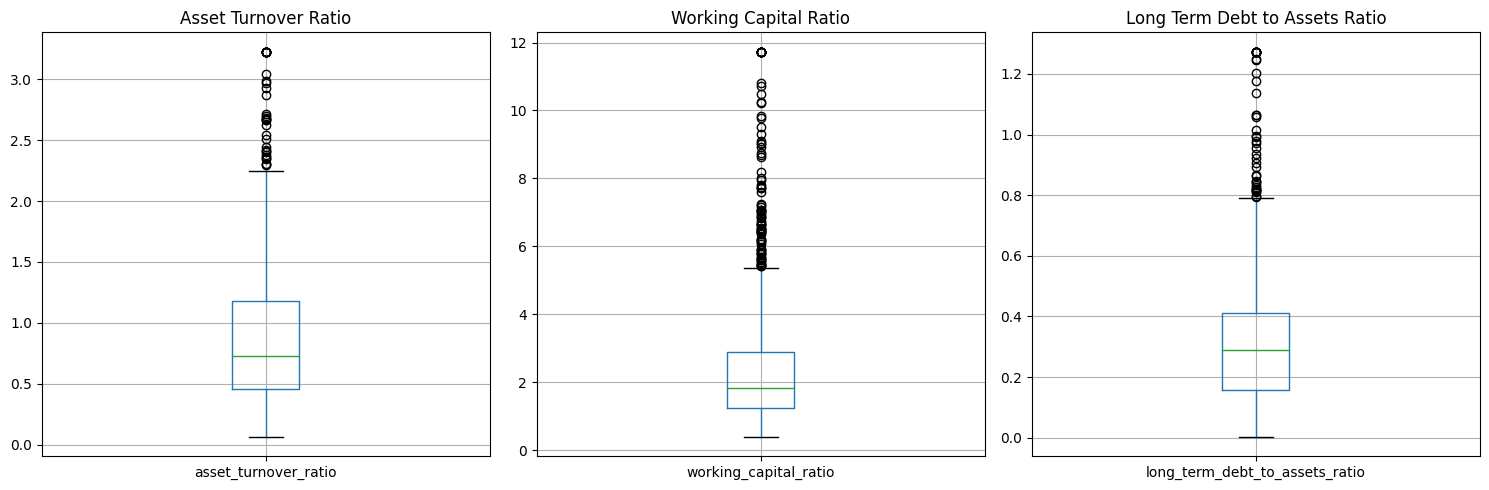

In [ ]:
# Creating a figure and axes object
fig_1, axes_1 = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plotting asset turnover ratio
print(stock['asset_turnover_ratio'].describe(), '\n')
stock.boxplot(column='asset_turnover_ratio', ax=axes_1[0])
axes_1[0].set_title('Asset Turnover Ratio')

# Plotting working capital ratio
print(stock['working_capital_ratio'].describe(), '\n')
stock.boxplot(column='working_capital_ratio', ax=axes_1[1])
axes_1[1].set_title('Working Capital Ratio')

# Plotting long term debt to assets ratio
print(stock['long_term_debt_to_assets_ratio'].describe(), '\n')
stock.boxplot(column='long_term_debt_to_assets_ratio', ax=axes_1[2])
axes_1[2].set_title('Long Term Debt to Assets Ratio')

plt.tight_layout()
plt.show()

After dealing with the outliers, next the three ratios will be classified as `high` or `low` based on their median value.

In [ ]:
# Classifying as high low
stock['high_ATR'] = (stock['asset_turnover_ratio'].gt(stock['asset_turnover_ratio'].median())).astype(int) # Asset Turover Ratio
stock['high_WCR'] = (stock['working_capital_ratio'].gt(stock['working_capital_ratio'].median())).astype(int) # Working Capital Ratio
stock['high_LTR'] = (stock['long_term_debt_to_assets_ratio'].gt(stock['long_term_debt_to_assets_ratio'].median())).astype(int) # Long term debt to assets ratio

In [ ]:
# Examining the dataframe
stock.head()

,gvkey,datadate,fyear,ticker,conm,act,at,dltt,lct,sale,description,asset_turnover_ratio,working_capital_ratio,long_term_debt_to_assets_ratio,high_ATR,high_WCR,high_LTR
0,1004,5/31/2023,2022,AIR,AAR CORP,1097.900,1833.100,317.900,351.500,1990.600,AAR Corp. provides products and services to co...,1.085920,3.123471,0.173422,1,1,0
1,1045,12/31/2023,2023,AAL,AMERICAN AIRLINES GROUP INC,13572.000,63058.000,35722.000,22062.000,52788.000,"American Airlines Group Inc., through its subs...",0.837134,0.615175,0.566494,1,0,1
2,1075,12/31/2023,2023,PNW,PINNACLE WEST CAPITAL CORP,1926.967,24661.153,8750.811,2889.347,4695.991,"Pinnacle West Capital Corporation, through its...",0.190421,0.666921,0.354842,0,0,1
3,1078,12/31/2023,2023,ABT,ABBOTT LABORATORIES,22670.000,73214.000,14548.000,13841.000,40109.000,"Abbott Laboratories discovers, develops, manuf...",0.547832,1.637887,0.198705,0,0,0
4,1161,12/31/2023,2023,AMD,ADVANCED MICRO DEVICES,16768.000,67885.000,2252.000,6689.000,22680.000,"Advanced Micro Devices, Inc. operates as a sem...",0.334094,2.506802,0.033174,0,1,0


Due to Colab's RAM limitations, limit the description size. We'll only keep 1st sentence of each description. In case if you have Pro subscription you can increase the number of sentences/try random sentences from descriptions/use full descriptions. (Observed improvement is marginal.)

In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
# Count the number of tokens in the 'text' column
stock['token_count'] = stock['description'].apply(lambda x: len(word_tokenize(x)))
print(stock.shape)
stock

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


(1259, 18)


,gvkey,datadate,fyear,ticker,conm,act,at,dltt,lct,sale,description,asset_turnover_ratio,working_capital_ratio,long_term_debt_to_assets_ratio,high_ATR,high_WCR,high_LTR,token_count
0,1004,5/31/2023,2022,AIR,AAR CORP,1097.900,1833.100,317.900,351.500,1990.600,AAR Corp. provides products and services to co...,1.085920,3.123471,0.173422,1,1,0,314
1,1045,12/31/2023,2023,AAL,AMERICAN AIRLINES GROUP INC,13572.000,63058.000,35722.000,22062.000,52788.000,"American Airlines Group Inc., through its subs...",0.837134,0.615175,0.566494,1,0,1,127
2,1075,12/31/2023,2023,PNW,PINNACLE WEST CAPITAL CORP,1926.967,24661.153,8750.811,2889.347,4695.991,"Pinnacle West Capital Corporation, through its...",0.190421,0.666921,0.354842,0,0,1,141
3,1078,12/31/2023,2023,ABT,ABBOTT LABORATORIES,22670.000,73214.000,14548.000,13841.000,40109.000,"Abbott Laboratories discovers, develops, manuf...",0.547832,1.637887,0.198705,0,0,0,299
4,1161,12/31/2023,2023,AMD,ADVANCED MICRO DEVICES,16768.000,67885.000,2252.000,6689.000,22680.000,"Advanced Micro Devices, Inc. operates as a sem...",0.334094,2.506802,0.033174,0,1,0,335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,317264,3/31/2023,2022,LPG,DORIAN LPG LTD,236.299,1708.914,739.039,94.597,392.151,"Dorian LPG Ltd., together with its subsidiarie...",0.229474,2.497954,0.432461,0,1,1,67
1255,325576,12/31/2023,2023,APG,API GROUP CORPORATION,2582.000,7590.000,2494.000,1807.000,6928.000,"APi Group Corporation provides safety, special...",0.912780,1.428888,0.328590,1,0,1,222
1256,326688,12/31/2023,2023,NVT,NVENT ELECTRIC PLC,1336.100,6161.700,1847.200,733.600,3263.600,"nVent Electric plc designs, manufactures, mark...",0.529659,1.821292,0.299787,0,1,1,304
1257,328795,12/31/2023,2023,ACA,ARCOSA INC,912.000,3577.900,591.600,431.200,2307.900,"Arcosa, Inc., together with its subsidiaries, ...",0.645043,2.115028,0.165348,0,1,0,238


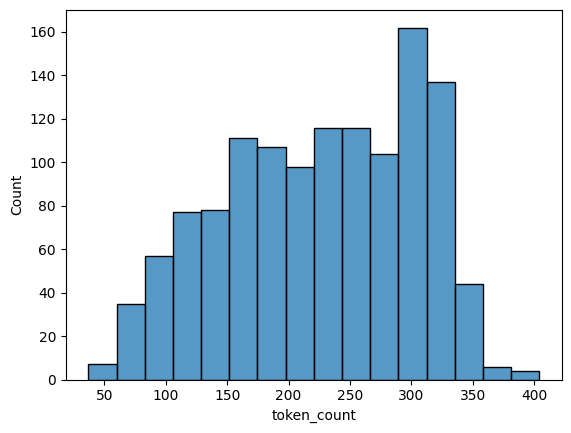

In [ ]:
# Plotting the token count
import seaborn as sns
sns.histplot(data=stock, x="token_count");

In [ ]:
import re
# Function to remove unusual characters
def remove_unusual_characters(text):
    pattern = r'[^a-zA-Z0-9.,?! ]'  # Pattern to match common English characters, numbers, and punctuation
    text = re.sub(pattern, '', text)
    return text

# Apply the function to the 'text' column
stock['text'] = stock['description'].apply(remove_unusual_characters)

In [ ]:
# Remove very long descriptions
lower_threshold = stock['token_count'].quantile(0.00)
upper_threshold = stock['token_count'].quantile(0.99)

# Trim the DataFrame based on the 1% thresholds
trimmed_df = stock[(stock['token_count'] >= lower_threshold) & (stock['token_count'] <= upper_threshold)]

trimmed_df

,gvkey,datadate,fyear,ticker,conm,act,at,dltt,lct,sale,description,asset_turnover_ratio,working_capital_ratio,long_term_debt_to_assets_ratio,high_ATR,high_WCR,high_LTR,token_count,text
0,1004,5/31/2023,2022,AIR,AAR CORP,1097.900,1833.100,317.900,351.500,1990.600,AAR Corp. provides products and services to co...,1.085920,3.123471,0.173422,1,1,0,314,AAR Corp. provides products and services to co...
1,1045,12/31/2023,2023,AAL,AMERICAN AIRLINES GROUP INC,13572.000,63058.000,35722.000,22062.000,52788.000,"American Airlines Group Inc., through its subs...",0.837134,0.615175,0.566494,1,0,1,127,"American Airlines Group Inc., through its subs..."
2,1075,12/31/2023,2023,PNW,PINNACLE WEST CAPITAL CORP,1926.967,24661.153,8750.811,2889.347,4695.991,"Pinnacle West Capital Corporation, through its...",0.190421,0.666921,0.354842,0,0,1,141,"Pinnacle West Capital Corporation, through its..."
3,1078,12/31/2023,2023,ABT,ABBOTT LABORATORIES,22670.000,73214.000,14548.000,13841.000,40109.000,"Abbott Laboratories discovers, develops, manuf...",0.547832,1.637887,0.198705,0,0,0,299,"Abbott Laboratories discovers, develops, manuf..."
4,1161,12/31/2023,2023,AMD,ADVANCED MICRO DEVICES,16768.000,67885.000,2252.000,6689.000,22680.000,"Advanced Micro Devices, Inc. operates as a sem...",0.334094,2.506802,0.033174,0,1,0,335,"Advanced Micro Devices, Inc. operates as a sem..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,317264,3/31/2023,2022,LPG,DORIAN LPG LTD,236.299,1708.914,739.039,94.597,392.151,"Dorian LPG Ltd., together with its subsidiarie...",0.229474,2.497954,0.432461,0,1,1,67,"Dorian LPG Ltd., together with its subsidiarie..."
1255,325576,12/31/2023,2023,APG,API GROUP CORPORATION,2582.000,7590.000,2494.000,1807.000,6928.000,"APi Group Corporation provides safety, special...",0.912780,1.428888,0.328590,1,0,1,222,"APi Group Corporation provides safety, special..."
1256,326688,12/31/2023,2023,NVT,NVENT ELECTRIC PLC,1336.100,6161.700,1847.200,733.600,3263.600,"nVent Electric plc designs, manufactures, mark...",0.529659,1.821292,0.299787,0,1,1,304,"nVent Electric plc designs, manufactures, mark..."
1257,328795,12/31/2023,2023,ACA,ARCOSA INC,912.000,3577.900,591.600,431.200,2307.900,"Arcosa, Inc., together with its subsidiaries, ...",0.645043,2.115028,0.165348,0,1,0,238,"Arcosa, Inc., together with its subsidiaries, ..."


In [ ]:
from nltk.tokenize import sent_tokenize
# Function to keep first three sentences
def keep_n_sentences(text):
    sentences = sent_tokenize(text)
    first_three_sentences = sentences[:1]
    return ' '.join(first_three_sentences)

# Apply the function to the 'text' column
trimmed_df['text'] = trimmed_df['text'].apply(keep_n_sentences)

In [ ]:
trimmed_df.head(3)

,gvkey,datadate,fyear,ticker,conm,act,at,dltt,lct,sale,description,asset_turnover_ratio,working_capital_ratio,long_term_debt_to_assets_ratio,high_ATR,high_WCR,high_LTR,token_count,text
0,1004,5/31/2023,2022,AIR,AAR CORP,1097.900,1833.100,317.900,351.500,1990.600,AAR Corp. provides products and services to co...,1.085920,3.123471,0.173422,1,1,0,314,AAR Corp. provides products and services to co...
1,1045,12/31/2023,2023,AAL,AMERICAN AIRLINES GROUP INC,13572.000,63058.000,35722.000,22062.000,52788.000,"American Airlines Group Inc., through its subs...",0.837134,0.615175,0.566494,1,0,1,127,"American Airlines Group Inc., through its subs..."
2,1075,12/31/2023,2023,PNW,PINNACLE WEST CAPITAL CORP,1926.967,24661.153,8750.811,2889.347,4695.991,"Pinnacle West Capital Corporation, through its...",0.190421,0.666921,0.354842,0,0,1,141,"Pinnacle West Capital Corporation, through its..."


# 4. Preparing the predictor and DistilBERT model

**Note**. Please enable GPU in Edit > Notebook settings > Hardware accelerator.

Load a pre-trained BERT model.

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights, max_length=2)
model = model_class.from_pretrained(pretrained_weights)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Tokenize the textual data for DistilBERT.

In [ ]:
trimmed_df.description[12]

"AMETEK, Inc. manufactures and sells electronic instruments and electromechanical devices worldwide. It operates in two segments, Electronic Instruments (EIG) and Electromechanical (EMG). The company's EIG segment offers advanced instruments for the process, aerospace, power, and industrial markets; process and analytical instruments for the oil and gas, petrochemical, pharmaceutical, semiconductor, automation, and food and beverage industries; and instruments to the laboratory equipment, ultra-precision manufacturing, medical, and test and measurement markets. This segment also provides power quality monitoring and metering devices, uninterruptible power supplies, programmable power equipment, electromagnetic compatibility test equipment, sensors for gas turbines, dashboard instruments for heavy trucks and other vehicles, and instrumentation and controls for the food and beverage industries; and aircraft and engine sensors, monitoring systems, power supplies, fuel and fluid measuremen

In [ ]:
trimmed_df.text[12]

'AMETEK, Inc. manufactures and sells electronic instruments and electromechanical devices worldwide.'

In [ ]:
tokenized = trimmed_df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Pad all lists of tokenized values to the same size.

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
np.array(padded).shape

(1246, 69)

Create attention mask variable for BERT to ignore (mask) the padding when it's processing its input.

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(1246, 69)

# DistilBERT model

We run the pretrained DistilBERT model on the prepared predictor and keep the result in `last_hidden_states` variable.

In [ ]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids,
                               attention_mask=attention_mask)

# Logistic regression model



Keep the first layer of the hidden states and assign the outcome variable to `labels`.

In [ ]:
trimmed_df

,gvkey,datadate,fyear,ticker,conm,act,at,dltt,lct,sale,description,asset_turnover_ratio,working_capital_ratio,long_term_debt_to_assets_ratio,high_ATR,high_WCR,high_LTR,token_count,text
0,1004,5/31/2023,2022,AIR,AAR CORP,1097.900,1833.100,317.900,351.500,1990.600,AAR Corp. provides products and services to co...,1.085920,3.123471,0.173422,1,1,0,314,AAR Corp. provides products and services to co...
1,1045,12/31/2023,2023,AAL,AMERICAN AIRLINES GROUP INC,13572.000,63058.000,35722.000,22062.000,52788.000,"American Airlines Group Inc., through its subs...",0.837134,0.615175,0.566494,1,0,1,127,"American Airlines Group Inc., through its subs..."
2,1075,12/31/2023,2023,PNW,PINNACLE WEST CAPITAL CORP,1926.967,24661.153,8750.811,2889.347,4695.991,"Pinnacle West Capital Corporation, through its...",0.190421,0.666921,0.354842,0,0,1,141,"Pinnacle West Capital Corporation, through its..."
3,1078,12/31/2023,2023,ABT,ABBOTT LABORATORIES,22670.000,73214.000,14548.000,13841.000,40109.000,"Abbott Laboratories discovers, develops, manuf...",0.547832,1.637887,0.198705,0,0,0,299,"Abbott Laboratories discovers, develops, manuf..."
4,1161,12/31/2023,2023,AMD,ADVANCED MICRO DEVICES,16768.000,67885.000,2252.000,6689.000,22680.000,"Advanced Micro Devices, Inc. operates as a sem...",0.334094,2.506802,0.033174,0,1,0,335,"Advanced Micro Devices, Inc. operates as a sem..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,317264,3/31/2023,2022,LPG,DORIAN LPG LTD,236.299,1708.914,739.039,94.597,392.151,"Dorian LPG Ltd., together with its subsidiarie...",0.229474,2.497954,0.432461,0,1,1,67,"Dorian LPG Ltd., together with its subsidiarie..."
1255,325576,12/31/2023,2023,APG,API GROUP CORPORATION,2582.000,7590.000,2494.000,1807.000,6928.000,"APi Group Corporation provides safety, special...",0.912780,1.428888,0.328590,1,0,1,222,"APi Group Corporation provides safety, special..."
1256,326688,12/31/2023,2023,NVT,NVENT ELECTRIC PLC,1336.100,6161.700,1847.200,733.600,3263.600,"nVent Electric plc designs, manufactures, mark...",0.529659,1.821292,0.299787,0,1,1,304,"nVent Electric plc designs, manufactures, mark..."
1257,328795,12/31/2023,2023,ACA,ARCOSA INC,912.000,3577.900,591.600,431.200,2307.900,"Arcosa, Inc., together with its subsidiaries, ...",0.645043,2.115028,0.165348,0,1,0,238,"Arcosa, Inc., together with its subsidiaries, ..."


In [ ]:
trimmed_df.columns

Index(['gvkey', 'datadate', 'fyear', 'ticker', 'conm', 'act', 'at', 'dltt',
       'lct', 'sale', 'description', 'asset_turnover_ratio',
       'working_capital_ratio', 'long_term_debt_to_assets_ratio', 'high_ATR',
       'high_WCR', 'high_LTR', 'token_count', 'text'],
      dtype='object')

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()
labels_atr = trimmed_df['high_ATR']
labels_wcr = trimmed_df['high_WCR']
labels_ltr = trimmed_df['high_LTR']

Split the data in train and test subsets, train the Logistic Regression on train set and evaluate its accuracy on the test set.

In [ ]:
features

array([[-3.8731557e-01,  1.4961691e-01, -2.8184766e-01, ...,
        -1.6794138e-02,  3.6573648e-01,  2.2608197e-01],
       [-4.8176309e-01,  3.6829751e-02, -4.3625304e-01, ...,
         2.9959377e-02,  8.2230866e-01,  4.8331752e-01],
       [-2.4885993e-01, -1.8762305e-01, -5.5357206e-01, ...,
         2.1956876e-01,  6.4488262e-01,  4.5061031e-01],
       ...,
       [-8.0068275e-02, -6.7734599e-02, -2.4268034e-01, ...,
         9.6595339e-02,  2.3763826e-01,  3.8666850e-01],
       [-4.6502256e-01, -3.0316856e-02, -3.2211888e-01, ...,
        -6.9567625e-04,  3.6244082e-01,  3.6046588e-01],
       [-4.4388247e-01, -1.7108768e-02, -4.2642131e-01, ...,
         1.5334630e-01,  4.4775397e-01,  3.6820424e-01]], dtype=float32)

In [ ]:
 # Model 1- Asset Turnover Ratio
train_features_atr, test_features_atr, train_labels_atr, test_labels_atr = train_test_split(features, labels_atr)
lr_clf_atr = LogisticRegression(max_iter=5000)
lr_clf_atr.fit(train_features_atr, train_labels_atr)
print(lr_clf_atr.score(test_features_atr, test_labels_atr))

0.6923076923076923


Check if this approach works better than a random guess (0.8 > 0.5).

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features_atr, train_labels_atr)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.507 (+/- 0.00)


In [ ]:
 # Model 2- Working Capital Ratio
train_features_wcr, test_features_wcr, train_labels_wcr, test_labels_wcr = train_test_split(features, labels_wcr)
lr_clf_wcr = LogisticRegression(max_iter=5000)
lr_clf_wcr.fit(train_features_wcr, train_labels_wcr)
print(lr_clf_wcr.score(test_features_wcr, test_labels_wcr))

0.6538461538461539


In [ ]:
 # Model 3- Long Term Debt to Assets Ratio
train_features_ltr, test_features_ltr, train_labels_ltr, test_labels_ltr = train_test_split(features, labels_ltr)
lr_clf_ltr = LogisticRegression(max_iter=5000)
lr_clf_ltr.fit(train_features_ltr, train_labels_ltr)
print(lr_clf_ltr.score(test_features_wcr, test_labels_ltr))

0.4967948717948718


From the above, it can be seen that the accuracy for the three ratios is as follows:

- `Asset Turnover Ratio`: 0.6923076923076923

- `Working Capital Ratio`: 0.6538461538461539

- `Long Term Debt to Assets Ratio`: 0.4967948717948718

In case of the `asset turnover ratio` accuracy is approximately 69%, for `working capital ratio` accuracy is approximately 65% and for the `long term debt to assets ratio` the accuracy is almost 50%. In all the three cases, the accuracy cannot be said to be high. In conclusion, although the accuracies offer initial indications of the model's performance, a thorough assessment involving additional metrics would be helpful in measuring the accuracy of the BERT/Logit model in forecasting each financial ratio.

If there were additional attributes that could be included in the model, then the accuracy would definitiely be higher as a company's business operations can be understood from considering various parameters together.